In [3]:
# Created 09.04.19 - Frederik Stihler
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import scipy.stats
import tensorflow as tf
import time
from datetime import datetime

# 1. Support Functions

In the following short part, some auxiliary functions are defined in order to simplify parts of the code later on

In [29]:
# function that checks for positive definiteness 
def is_pos_def(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)

# function that checks if all eigenvalues of a matrix are less than unity in modulus
def are_eigenvals_less1(matrix):
    return np.all(np.abs(np.linalg.eigvals(matrix)) < 1)

# function that calculates the quadratic form of two vectors x,y and a matrix A
def qf(x,A,y):
    return np.transpose(x)@A@y

# function that calculates the transpose of a matrix
def tra(matrix):
    return np.transpose(matrix)
            
# function that creates a random covariance matrix based on a given standard deviation vector
def covariance_matrix_random(size_n,std_dev=None):
    sample_drawn = np.random.uniform(0, 1, size=(size_n,100)) 
    if std_dev is None:
        return np.cov(sample_drawn)
    else:
        corr_coef_matrix = np.corrcoef(sample_drawn)
        if size_n == 1:
            corr_coef_matrix = np.array([[corr_coef_matrix]])
        assert len(std_dev)==size_n, 'dimension error in standard deviation vector: It does not match size_n input'
        std_dev_matrix = np.diag(std_dev)
        cov_matrix = std_dev_matrix@corr_coef_matrix@std_dev_matrix
        return cov_matrix

# 2. Setting up the Execution Cost Model

In the next part, the python class for the optimal execution cost model is created. It is fed with a configuration object (config) that contains all specifications defined in the 'Configurations for different experiments' part.

First, all model parameters are initialized with realistic, but artificially created values. Second, the model dynamics are specified, which includes two functions that create sample simulations for the no-impact price development and the evolution of market conditions and information over time. These functions are used to create the training data for the deep neural network. 

Next, the optimal analytical solution to the execution cost model is calculated via dynamic programming. The detailed algorithm for deriving this solution is specified in the article "Optimal Control of Execution Costs for Portfolios􏰞" (1999) by Dimitris Bertsimas, 􏰟 Paul Hummel 􏰟 and Andrew W􏰠. Lo.

Finally, several functions to evaluate the performance of a trained network on test data are defined. For example, a function that extracts the trained weights of a neural network in TensorFlow is required.

In [30]:
## Execution Cost Model (ECM) class
class ECM():
    
    def __init__(self, config):
        
        np.random.seed(2)
        self.T = config.T
        self.n = config.n
        self.m = config.m
        self.a_bar = np.ones(self.n)*config.a_bar
        
        self.layers = config.layers
        self.neurons = config.neurons
        
        self.valid_sample_size = config.valid_sample_size
        
        ### linear percentage price impact model
        
        ## the random no-impact price development is modelled as multivariate geometric Brownian motion:
        
        # random initial no-impact prices (p_start)
        self.p_start = np.random.uniform(1, 100, size=self.n)
        # drift (mu_z)
        self.mu_z = np.random.normal(0, 1e-5, size=self.n)
        # volatility (Sigma_z)
        self.Sigma_z = covariance_matrix_random(self.n, std_dev=np.random.uniform(0.01, 0.1, size=self.n))
        
        ## price impact dynamics 
        
        # sensitivity of price impact to trade size (Matrix A); (A must be positive definite)
        self.A_factor = config.A_factor
        self.A = np.diag(4*self.A_factor*np.ones(self.n)) + np.random.uniform(-self.A_factor, self.A_factor, size=(self.n,self.n))
        #self.A = fix_matrix_A() #A could be inserted by hand
        assert is_pos_def(self.A), 'Matrix A is not positive definite'
        # sensitivity of price impact to changing market conditions (Matrix B)
        self.B = np.random.uniform(0.5e-4, 1.5e-4, size=(self.n,self.m))
        # random initial market conditions (x_start)
        self.x_start = np.random.normal(0, 0.5, size=self.m)
        
        ## the evolution of market conditions is modelled as vector autoregressive process with one lag:
        # degree of predictability in market conditions (Matrix C), C must have eigenvalues less than unity in modulus
        self.C = np.random.uniform(0, 0.5, size=(self.m, self.m))
        assert are_eigenvals_less1(self.C), 'Matrix C has |eigenvalues| > 1'
        # white noise with mean 0 (wn_mean) and covariance matrix (wn_cov)
        self.wn_mean = np.zeros(self.m)
        self.wn_cov = covariance_matrix_random(self.m, std_dev=np.random.uniform(0.5,1 , size=self.m))
        
        # execute the calculation of the dynamic programming solution
        self.DP_sol()
        
    # sample simulation of the no-impact price with variable sample size (geom. Brownian Motion)
    def P_simu(self, sample_size):
        P_simu = np.zeros((sample_size, self.n, self.T))
        p_tilde_t = np.ones((sample_size, self.n))*self.p_start
        P_simu[:,:,0] = p_tilde_t
        for t in np.arange(1, self.T):
            z_t = np.random.multivariate_normal(self.mu_z, self.Sigma_z, size=sample_size)
            p_tilde_t = p_tilde_t*np.exp(z_t)
            P_simu[:,:,t] = p_tilde_t
        return P_simu
        
        
    # sample simulation of the market conditions with variable sample size (autoregressive process with one lag AR(1))  
    def X_simu(self, sample_size):
        X_simu = np.zeros((sample_size, self.m, self.T))
        x_t = np.ones((sample_size, self.m))*self.x_start
        X_simu[:,:,0] = x_t
        for t in np.arange(1, self.T):
            eta_t = np.random.multivariate_normal(self.wn_mean, self.wn_cov, size=sample_size)
            x_t = x_t@np.transpose(self.C)+eta_t
            X_simu[:,:,t] = x_t
        return X_simu
        
        
        
    # calculation of the analytical optimal solution of the model with the dynamic programming algorithm    
    def DP_sol(self):
    
        I = np.identity(self.n)
        en = np.ones((self.n,1))
        er = np.ones((self.m,1))
        Q = np.diag(np.exp(self.mu_z+0.5*np.diag(self.Sigma_z)))
        R = np.zeros((self.n, self.n))
        for i in range(0, self.n):
            for j in range(i,self.n):
                R[i][j] = np.exp(self.mu_z[i]+self.mu_z[j]+0.5*(self.Sigma_z[i][i]+self.Sigma_z[j][j]+2*self.Sigma_z[i][j]))
                if i!=j:
                    R[j][i] = R[i][j]         
        
        A = self.A
        B = self.B
        C = self.C
        x_start = self.x_start   
        # purchasing order expressed in terms of currency-to-trade (price * number of stocks)
        a_bar_curr = self.a_bar*self.p_start
    
        delta_x = np.linalg.inv((tra(self.A)+tra(self.A)*R)+tra(tra(self.A)+tra(self.A)*R))@(Q@self.B@self.C-self.B)
        delta_u = np.linalg.inv((tra(self.A)+tra(self.A)*R)+tra(tra(self.A)+tra(self.A)*R))@(tra(self.A)*R+self.A*R)
        delta_1 = np.linalg.inv((tra(self.A)+tra(self.A)*R)+tra(tra(self.A)+tra(self.A)*R))@(Q-I)
        
        Dn = (tra(delta_1)@(tra(self.A)+tra(self.A)*R)+(I-Q))@delta_1
        E = (tra(delta_1)@(tra(self.A)+tra(self.A)*R)+(I-Q))@delta_x
        F = (tra(delta_x)@(tra(self.A)+tra(self.A)*R)+(tra(self.B)-tra(self.C)@tra(self.B)@Q))@delta_1
        G = (tra(delta_x)@(tra(self.A)+tra(self.A)*R)+(tra(self.B)-tra(self.C)@tra(self.B)@Q))@delta_x
        H = (tra(delta_x)@(tra(self.A)+tra(self.A)*R)+(tra(self.B)-tra(self.C)@tra(self.B)@Q))@delta_u - tra(delta_x)@(tra(self.A)*R) + tra(self.C)@tra(self.B)@Q
        J = (tra(delta_u)@(tra(self.A)+tra(self.A)*R)-tra(self.A)*R)@delta_x
        K = (tra(delta_1)@(tra(self.A)+tra(self.A)*R)+(I-Q))@delta_u - tra(delta_1)@(tra(self.A)*R) + Q
        L = (tra(delta_u)@(tra(self.A)+tra(self.A)*R)-tra(self.A)*R)@delta_1
        N = (tra(delta_u)@(tra(self.A)+tra(self.A)*R)-tra(self.A)*R)@delta_u - tra(delta_u)@(tra(self.A)*R) + tra(self.A)*R
        
        
        # arrays that keep track of the evolution of the intermediate results (delta_(x/u/1)) in order to calculate the best execution strategy later on
        delta_x_evol = np.zeros((self.T,self.n,self.m))
        delta_x_evol[0,:,:] = delta_x
        delta_u_evol = np.zeros((self.T,self.n,self.n))
        delta_u_evol[0,:,:] = delta_u
        delta_1_evol = np.zeros((self.T,self.n,self.n))
        delta_1_evol[0,:,:] = delta_1
        
        for t in range(1,self.T-1):
            
            ANR = tra(A)+N*R
            IKQ = I-K@Q
            BCHQ = tra(B)-tra(C)@H@Q
            
            delta_x = np.linalg.inv(ANR+tra(ANR))@(Q@(tra(H)+J)@C-B)
            delta_x_evol[t,:,:] = delta_x
            delta_u = np.linalg.inv(ANR+tra(ANR))@(N*R+tra(N)*R)
            delta_u_evol[t,:,:] = delta_u
            delta_1 = np.linalg.inv(ANR+tra(ANR))@(Q@(tra(K)+tra(L))-I)
            delta_1_evol[t,:,:] = delta_1
            
            Dn = (tra(delta_1)@ANR+IKQ)@delta_1-tra(delta_1)@Q@L+Dn
            Dr = self.wn_cov*G
            E = (tra(delta_1)@ANR+IKQ)@delta_x-tra(delta_1)@Q@J@C+E@C
            F = (tra(delta_x)@ANR+BCHQ)@delta_1-tra(delta_x)@Q@L+tra(C)@F
            G = (tra(delta_x)@ANR+BCHQ)@delta_x-tra(delta_x)@Q@J@C+tra(C)@G@C
            H = (tra(delta_x)@ANR+BCHQ)@delta_u-tra(delta_x)@(N*R)+tra(C)@H@Q
            J = (tra(delta_u)@ANR-N*R)@delta_x+(I-tra(delta_u))@Q@J@C
            K = (tra(delta_1)@ANR+IKQ)@delta_u-tra(delta_1)@(N*R)+K@Q
            L = (tra(delta_u)@ANR-N*R)@delta_1+(I-tra(delta_u))@Q@L
            N = (tra(delta_u)@ANR-N*R)@delta_u+(I-tra(delta_u))@(N*R)

        self.delta_x = delta_x_evol
        self.delta_u = delta_u_evol
        self.delta_1 = delta_1_evol
    
        # calculate the total execution cost (C_T) and total execution cost in cents/share above the no-impact cost (C_T_D)
        self.C_T = qf(en,Dn,en)+qf(er,Dr,er)+qf(en,E,x_start)+qf(x_start,F,en)+qf(x_start,G,x_start)+\
                qf(x_start,H,a_bar_curr)+qf(a_bar_curr,J,x_start)+qf(en,K,a_bar_curr)+qf(a_bar_curr,L,en)+qf(a_bar_curr,N,a_bar_curr)
                
        self.C_T_D = float(100*(self.C_T[0][0]-np.sum(self.a_bar*self.p_start))/np.sum(self.a_bar))
        
    # the following functions are all required to evaluate the performance of a trained network on test data
    # they are essentially the same as in the 'TensorFlow Graph Construction' part 
    
    # function that extracts the trained parameters of a TensorFlow graph, to measure network performance on test data
    def extract_trained_params(self, trainable_params):
        
        def extract_trainable_params(params):
            new_list = []
            for i in range(0,self.layers-1):
                new_list.append(copy_layer_info(params[i]))
            return new_list
        
        def copy_layer_info(params_):
            layer_info = {}
            layer_info.update({'w': params_['w'].eval()})
            layer_info.update({'beta': params_['beta'].eval()})
            layer_info.update({'gamma': params_['gamma'].eval()})    
            return layer_info
        
        self.trainable_params = {}
        self.trainable_params.update({'1': trainable_params['1'].eval()})
        for t in range(2, self.T):
            self.trainable_params.update({str(t): extract_trainable_params(trainable_params[str(t)])})
        
    # function that calculates the output of the overall trained deep neural network
    def DNN_cost_trained(self, P_simu, X_simu, case = 'train'):
        sample_size = P_simu.shape[0]
        ones = np.ones((sample_size,1))
        u = 0.0+(ones*self.a_bar)
        cumul_cost = 0.0
        
        for t in range(0, self.T-1):
            if t == 0:
                a_t = ones@self.trainable_params['1']
            else:
                a_t = Subnetwork_t_trained(t, u, P_simu[:,:,t], X_simu[:,:,t], self.trainable_params[str(t+1)], case=case)
                
            c_t = intermediate_cost_trained(self, P_simu[:,:,t], X_simu[:,:,t], a_t)
            cumul_cost += c_t
            u -= a_t
        
        cumul_cost += intermediate_cost_trained(self, P_simu[:,:,self.T-1], X_simu[:,:,self.T-1], u)
        cumul_cost = 100*(cumul_cost-np.sum(self.a_bar*self.p_start))/np.sum(self.a_bar)
        
        return cumul_cost
    
    # function that calculates the optimal trades and execution costs based on the dynamic programming solution
    def optimal_cost_trained(self, P_simu, X_simu):
        sample_size = P_simu.shape[0]
        ones = np.ones((sample_size,1))
        ones_n = np.ones((self.n, sample_size))
        u = 0.0 + (ones*self.a_bar)
        cost_opti = 0.0
        
        for t in np.arange(0, self.T-1):
            u_curr = tra(u*P_simu[:,:,t])
            a_t_opti = tra(self.delta_x[self.T-2-t]@tra(X_simu[:,:,t]) + self.delta_u[self.T-2-t]@u_curr+ self.delta_1[self.T-2-t]@ones_n)
            a_t_opti /= P_simu[:,:,t]
            cost_t = intermediate_cost_trained(self, P_simu[:,:,t], X_simu[:,:,t], a_t_opti)
            cost_opti += cost_t
            u -= a_t_opti
                          
        cost_opti += intermediate_cost_trained(self, P_simu[:,:,self.T-1], X_simu[:,:,self.T-1], u)
        cost_opti = 100*(cost_opti-np.sum(self.a_bar*self.p_start))/np.sum(self.a_bar)
        return cost_opti                  
        
    # function that calculates the total relative control error
    def relative_control_error_trained(self, P_simu, X_simu, case='train'):
        sample_size = P_simu.shape[0]
        ones = np.ones((sample_size,1))
        ones_n = np.ones((self.n, sample_size))
        a_t_opti = np.zeros((sample_size, self.n, self.T-1))
        a_t_DNN = np.zeros((sample_size, self.n, self.T-1))
        u = 0.0 + (ones*self.a_bar)
                          
        for t in range(0,self.T-1):
            if t == 0:
                a_t_DNN[:,:,t] = ones@self.trainable_params['1']
            else:
                a_t_DNN[:,:,t] = Subnetwork_t_trained(t, u, P_simu[:,:,t], X_simu[:,:,t], self.trainable_params[str(t+1)], case=case)
            
            u_curr = tra(u*P_simu[:,:,t])
            a_t = tra(self.delta_x[self.T-2-t]@tra(X_simu[:,:,t]) + self.delta_u[self.T-2-t]@u_curr+self.delta_1[self.T-2-t]@ones_n)
            a_t /= P_simu[:,:,t]
            u -= a_t
            a_t_opti[:,:,t] = a_t
        return np.mean(abs(a_t_opti-a_t_DNN)/a_t_opti)
    
                          
    def fix_matrix_A(self):
        self.A = np.zeros((self.n,self.n))
        for i in range(0,self.n):
            for j in range(0,self.n):
                print('A[',i,'][',j,'] =', end =" ") 
                self.A[i][j]=(float(input()))
        print('A = ')
        print(self.A)
        return A

# function that passes inputs of a test data set through one trained subnetwork SN_t    
def Subnetwork_t_trained(t, u, p_t_tilde, x_t, trainable_params, case):
    if t>1:
        if case == 'train':
            batch_mean = np.mean(u, axis = 0)
            batch_variance = np.var(u, axis = 0)
        elif case == 'update':
            batch_mean = np.mean(u, axis = 0)
            batch_variance = np.var(u, axis = 0)
            u_d = {'mean': batch_mean, 'variance': batch_variance}
            trainable_params.append(u_d)
        elif case == 'test':
            u_d = trainable_params[-1]
            batch_mean = u_d['mean']
            batch_variance = u_d['variance']
        else:
            assert False, 'case error'
        u = (u-batch_mean)/np.sqrt(batch_variance+1e-10)
            
    inputs = np.concatenate([u, p_t_tilde, x_t],1)
    hidden_1 = next_layer_trained(inputs, trainable_params[0], case)
    hidden_2 = next_layer_trained(hidden_1, trainable_params[1], case)
    a_t = next_layer_trained(hidden_2, trainable_params[2], case, layer='final')
    return a_t

# funtion that calculates the average intermediate cost over test data trading decisions a_t
def intermediate_cost_trained(ecm, p_t_tilde, x_t, a_t):
    intermediate_cost_matrix = p_t_tilde*(1+(p_t_tilde*a_t)@tra(ecm.A)+x_t@tra(ecm.B))*a_t
    return np.mean(intermediate_cost_matrix)*ecm.n
        
# function that passes on the signals to the next layer within a subnetwork            
def next_layer_trained(in_, trainable_param, case, layer=None):
    activation = in_@(trainable_param['w'])
    if case == 'train':
        batch_mean = np.mean(activation, axis = 0)
        batch_variance = np.var(activation, axis = 0)
    elif case == 'update':
        batch_mean = np.mean(activation, axis = 0)
        batch_variance = np.var(activation, axis = 0)
        trainable_param['mean'] = batch_mean
        trainable_param['variance'] = batch_variance
    elif case == 'test':
        batch_mean = trainable_param['mean']
        batch_variance = trainable_param['variance']
    else:
        assert False, 'case error'
        
    BN = ((activation-batch_mean)/np.sqrt(batch_variance+1e-10))*trainable_param['gamma']+trainable_param['beta']
    
    if layer == 'final':
        return BN
    else:
        out_ = np.maximum(0, BN)
        return out_ 
        
        

# 3. TensorFlow Graph Construction

In this part, the computation graph for the deep neural network is set up in TensorFlow. This is done by feeding in an execution cost model object that has been configured in advance.

In the beginning, the fixed values of the execution cost model are transformed into TensorFlow constants for the computation graph. Afterwards, a function that creates the weights for each subnetwork is defined. 

Next, the graph construction is finalized by defining all functions necessary to pass on information through the network and keep track of the cumulative costs. This includes for example a function that calculates the intermediate cost of taking an action at a specific time in a given state and a function that propagates signals to the next layer in a subnetwork.

In [39]:
# Tensorflow graph construction
tfg = tf.Graph()

# create ECM-class for Tensorflow graph and transform model parameters into TF.constants
class ECM_TF():
    def __init__(self, ecm):
        self.T = ecm.T
        self.n = ecm.n
        self.m = ecm.m
        self.a_bar = ecm.a_bar
        
        self.layers = ecm.layers
        self.neurons = ecm.neurons
        
        self.valid_sample_size = ecm.valid_sample_size
        self.ones_sample = tf.constant(np.ones((self.valid_sample_size,1)), dtype=tf.float64)
        
        self.p_start = tf.constant(ecm.p_start, dtype=tf.float64)
        self.mu_z = tf.constant(ecm.mu_z, dtype=tf.float64)
        self.Sigma_z = tf.constant(ecm.Sigma_z, dtype=tf.float64)
        
        self.A = tf.constant(ecm.A, dtype=tf.float64)
        self.A_T = tf.constant(tra(ecm.A), dtype=tf.float64)
        self.B = tf.constant(ecm.B, dtype=tf.float64)
        self.B_T = tf.constant(tra(ecm.B), dtype=tf.float64)
        
        self.C = tf.constant(ecm.C, dtype=tf.float64)
        self.C_T = tf.constant(tra(ecm.C), dtype=tf.float64)
        self.x_start = tf.constant(ecm.x_start, dtype=tf.float64)
        self.wn_mean = tf.constant(ecm.wn_mean, dtype=tf.float64)
        self.wn_cov = tf.constant(ecm.wn_cov, dtype=tf.float64)
        

# function that creates the trainable parameters of a subnetwork (weights and batch normalization parameters)
def trainable_params_initialization(ecm_tf):
    trainable_params = []
    def layer_initialization(in_, out_, layer):
        layer_dict = {}
        std_dev_w = 2 / np.sqrt(in_ + out_)
        layer_dict['w'] = tf.Variable(tf.truncated_normal([in_,out_], stddev=std_dev_w, dtype = tf.float64,seed=2), name='w'+str(layer))
        layer_dict['beta'] = tf.Variable(tf.random_normal([out_], stddev=3, dtype = tf.float64,seed=2), name='beta'+str(layer))
        layer_dict['gamma'] = tf.Variable(tf.random_uniform([out_], minval=0.1, maxval=5, dtype = tf.float64,seed=2), name='gamma'+str(layer))
        return layer_dict
    for i in range(0,ecm_tf.layers-1):
        trainable_params.append(layer_initialization(ecm_tf.neurons[i],ecm_tf.neurons[i+1], i))
    return trainable_params

# funtion that calculates the average intermediate cost over a given batch of trading decisions a_t
def intermediate_cost(ecm_tf, p_t_tilde, x_t, a_t):
    intermediate_cost_matrix = p_t_tilde*(1+tf.matmul(p_t_tilde*a_t,ecm_tf.A_T)+tf.matmul(x_t,ecm_tf.B_T))*a_t
    return tf.reduce_mean(intermediate_cost_matrix)*ecm_tf.n

def batch_normalization(out_, beta, gamma):
    batch_mean, batch_variance = tf.nn.moments(out_, axes=[0], name='moments')
    normalized_out = tf.nn.batch_normalization(out_, batch_mean, batch_variance, beta, gamma, 1e-10, name='batch_normalization')
    return normalized_out

# function that passes on the signals to the next layer within a subnetwork
def next_layer(in_, trainable_params, layer=None):    
    weighted_sum = tf.matmul(in_, trainable_params['w'])
    BN = batch_normalization(weighted_sum, trainable_params['beta'], trainable_params['gamma'])
    if layer == 'final':
        return BN
    else:
        out_ = tf.nn.relu(BN)
        return out_ 

# function that passes input values of a given data set (e.g. training batch/validation set) through one subnetwork SN_t
def Subnetwork_t(tfg, ecm_tf, t, u_t, p_t_tilde, x_t, trainable_params):
        if t>2:
            u_t = batch_normalization(u_t, beta=None, gamma=None)
        s_t = tf.concat([u_t, p_t_tilde, x_t],1)
        hidden_1 = next_layer(s_t, trainable_params[0])
        hidden_2 = next_layer(hidden_1, trainable_params[1])
        a_t = next_layer(hidden_2, trainable_params[2], layer='final')
        c_t = intermediate_cost(ecm_tf, p_t_tilde, x_t, a_t)
        return c_t, a_t

    
# function that calculates the output of the overall deep neural network (total cumulative cost)
# by passing an initial state and a sample of the stochastic processes of the no-impact prices (P_sim) and of the market information (X_sim)
# to the full deep neural network, which consists of the subnetworks at each time step
# Simultaneously, it calculates the relative error of the controls to the optimal execution strategy
def DNN_cost(tfg, ecm_tf, ecm, ones, P_sim, X_sim, trainable_params):
    with tfg.as_default():
        # shares outstanding (u_t)
        # shares outstanding in calculation of error (u_t_e)
        u_t = ones*ecm_tf.a_bar
        u_t_e = ones*ecm_tf.a_bar #used to compare network decision against optimal solution
        ones_n = ones*tf.constant(np.ones((1,ecm.n)), dtype=tf.float64)
        cumul_cost = 0
        error = 0
        
        
        a_t = tf.matmul(ones, trainable_params['1'])
        a_t_e = tf.matmul(ones, trainable_params['1']) #used to compare network decision against optimal solution
        a_t_optimal = a_t_opti(u_t_e, P_sim[:,:,0], X_sim[:,:,0], ones_n, ecm, ecm.T-2)
        c_t = intermediate_cost(ecm_tf, P_sim[:,:,0], X_sim[:,:,0], a_t)
        cumul_cost += c_t
        error += relative_error(a_t_optimal, a_t_e)
        u_t_e = tf.subtract(u_t_e, a_t_optimal)
        
        
        for t in range(1, ecm_tf.T-1): 
            u_t = tf.subtract(u_t, a_t)
            c_t, a_t = Subnetwork_t(tfg, ecm_tf, t+1, u_t, P_sim[:,:,t], X_sim[:,:,t], trainable_params[str(t+1)])
            cumul_cost += c_t
            u_t_e, error = Subnetwork_error(tfg, ecm_tf, ecm, t, u_t_e, P_sim[:,:,t], X_sim[:,:,t], ones_n, error, trainable_params)
                
        u_t = tf.subtract(u_t,a_t)
        cumul_cost += intermediate_cost(ecm_tf, P_sim[:,:,ecm_tf.T-1], X_sim[:,:,ecm_tf.T-1], u_t) #last trade is not decided by net
        cumul_cost_D = 100*(cumul_cost-tf.reduce_sum(ecm.a_bar*ecm.p_start))/tf.reduce_sum(ecm.a_bar)
        
        return cumul_cost_D, error/(ecm.T-1) 

# function that calculates the relative error of the controls at a time step compared to the optimal execution strategy
def relative_error(a_t_opti, a_t):
    return tf.reduce_mean(tf.abs(a_t_opti-a_t/a_t_opti))

# function that calculates the optimal trade based on the dynamic programming solution
def a_t_opti(u_t, p_t_tilde, x_t, ones_n, ecm, index):
    u_curr = u_t*p_t_tilde
    a_t_opti = tf.matmul(x_t,tra(ecm.delta_x[index]))+tf.matmul(u_curr,tra(ecm.delta_u[index]))+tf.matmul(ones_n,tra(ecm.delta_1[index]))
    a_t_opti = a_t_opti/p_t_tilde
    return a_t_opti

# function that supports the calculation of the total relative control error
def Subnetwork_error(tfg, ecm_tf, ecm, t, u_t_e, p_t_tilde, x_t, ones_n, error, trainable_params):
    _ , a_t_e = Subnetwork_t(tfg, ecm_tf, t+1, u_t_e, p_t_tilde, x_t, trainable_params[str(t+1)])
    a_t_optimal = a_t_opti(u_t_e, p_t_tilde, x_t, ones_n, ecm, ecm.T-2-t)
    u_t_e = u_t_e-a_t_optimal
    error = error + relative_error(a_t_optimal, a_t_e)
    return u_t_e, error


# 4. Configurations for different experiments

The following part allows different configurations of model parameters for different experiments, such as the time horizon, the number of stocks in the portfolio and the order size. Furthermore, the overall architecture of the subnetworks approximating the controls at each time step is defined here. Lastly, the training specifications are selected, such as the batch size and maximum iteration steps etc.

In [40]:
# Configurations for the experiment

class Config(object):
    
    # Number of time periods T
    T = 20
    
    # Number of stocks
    n = 10
    
    # Order size (a_bar), number of the n stocks to be purchased within time T (assumed to be equal for all stocks)
    a_bar = 10
    A_factor = 0.0001
    
    # Number of sources of different market conditions
    m = 3
    
    # Subnetwork architecture
    hidden_layers_N = 2
    layers = 2+hidden_layers_N
    neurons = [2*n+m,100,100,n]
    
    # Training specifications
    run = 5
    batch_size = 64
    valid_sample_size = 8*batch_size
    maxstep = 15000
    step_boundaries = [int(0.15*maxstep), int(0.8*maxstep), int(0.9*maxstep)]
    learning_rate_incr = [0.005, 0.001, 0.00075, 0.0005]
    learning_rate = 0.001
    displaystep = 250
    history_length = int(maxstep/displaystep)-1

# 5. TensorFlow Session and Training 

Here, the input nodes of the final TensorFlow graph are initialized. Moreover, the loss of the deep neural network is defined and an optimization algorithm is chosen. In a TensorFlow session, training data is generated and fed to the graph. Based on the calculated loss, the optimizer then modifies the weights in the neural network. The performance improvement is monitored via a validation sample. After the training process, a summary of the results is presented.

In [41]:
# Training
summaries = []
config = Config()   
ecm = ECM(config)
print('Analytical solution of the model: total cost ', ecm.C_T, ' per share ',ecm.C_T_D)


    
for ab in np.arange(3):
    print('---- T:', config.T,' ----')
    tfg = tf.Graph()
    with tfg.as_default():
        ecm_tf = ECM_TF(ecm)
        p_tilde_t = tf.placeholder(tf.float64, [None, ecm.n, ecm.T], name = 'p_tilde_t')
        x_t = tf.placeholder(tf.float64, [None, ecm.m, ecm.T], name = 'x_t')
        ones = tf.placeholder(tf.float64, [None, 1], name = 'ones')

        # initialize a dictionary containing all trainable parameters of the DNN (of each subnetwork)
        trainable_params = {}
        trainable_params.update({'1': tf.Variable(tf.random_uniform((1,ecm.n), minval=-config.a_bar, maxval=config.a_bar, dtype=tf.float64,seed=2))})
        for t in range(2, ecm.T):
            trainable_params.update({str(t): trainable_params_initialization(ecm)})

        # define output of TensorFlow graph
        C_T_D, RCE = DNN_cost(tfg, ecm_tf, ecm, ones, p_tilde_t, x_t, trainable_params)

        global_step = tf.Variable(0, trainable=False)
        learning_rate_s = tf.train.piecewise_constant(global_step, config.step_boundaries, config.learning_rate_incr)
        optimizer = tf.train.AdamOptimizer(learning_rate = config.learning_rate).minimize(C_T_D) # C_T_D is the loss
        #optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate_s).minimize(C_T_D, global_step=global_step)

        summary = {'validation_cost_history': np.zeros((config.history_length,config.run)),\
                  'RCE_history': np.zeros((config.history_length,config.run)),\
                  'time': np.zeros([1,config.run]),\
                  'validation_cost_analytic': np.zeros([1,config.run]),\
                  'test_cost_analytic': np.zeros([1,config.run]),\
                  'test_cost_network': np.zeros([1,config.run]),\
                  'test_RCE': np.zeros([1,config.run])}
        summary['iteration'] = (np.arange(config.history_length)+1)*config.displaystep



        # perform training

        for i_run in np.arange(config.run):
            print('')
            print('---- run: ',i_run+1,' ----')
            temp_batch_size = config.batch_size
            temp_boundaries = list.copy(config.step_boundaries)
            p_tilde_t_validation = ecm.P_simu(config.valid_sample_size)
            x_t_validation = ecm.X_simu(config.valid_sample_size)
            ones_validation = np.ones((config.valid_sample_size,1))
            ones_batch = np.ones((config.batch_size,1))
            feed_dict_validation = {p_tilde_t: p_tilde_t_validation, x_t: x_t_validation, ones: ones_validation}
            print('valididation_cost_analytic: ', ecm.optimal_cost_trained(p_tilde_t_validation,x_t_validation))



            if 'sess' in globals():
                sess.close()
                del sess
            sess = tf.InteractiveSession()
            init = tf.global_variables_initializer()
            sess.run(init)

            step = 1
            print('cost start: ',sess.run(C_T_D, feed_dict=feed_dict_validation))
            temp_cost_history = []
            temp_RCE_history = []
            boundary = temp_boundaries.pop(0)
            start_time = time.time()
            while step <= config.maxstep:

                if step%config.displaystep == 0:
                    execution_cost = sess.run(C_T_D, feed_dict=feed_dict_validation)
                    relative_control_error = sess.run(RCE, feed_dict=feed_dict_validation)
                    #print('step: ',step,' batch_size, lr: ',temp_batch_size,' ',learning_rate.eval(),' exec. cost: ',execution_cost,' RCE: ',relative_control_error)
                    print('step: ', step, ' exec. cost: ',execution_cost,' RCE: ',relative_control_error)
                    if step!=250:
                        temp_cost_history.append(execution_cost)
                        temp_RCE_history.append(relative_control_error)

                p_tilde_t_train = ecm.P_simu(temp_batch_size)
                x_t_train = ecm.X_simu(temp_batch_size)
                sess.run(optimizer, feed_dict={p_tilde_t: p_tilde_t_train, x_t: x_t_train, ones: ones_batch})


                step += 1
                if (step>boundary):
                    if(len(temp_boundaries)>0):
                        boundary = temp_boundaries.pop(0)
                    else:
                        boundary = config.maxstep+1
                    temp_batch_size = temp_batch_size*2
                    ones_batch = np.ones((temp_batch_size,1))
            elapsed_time = time.time()-start_time
            print('---', elapsed_time, ' seconds---')
            summary['time'][0,i_run] = elapsed_time
            summary['validation_cost_history'][:,i_run] = temp_cost_history
            summary['RCE_history'][:,i_run] = temp_RCE_history
            summary['validation_cost_analytic'][0,i_run] = ecm.optimal_cost_trained(p_tilde_t_validation,x_t_validation)
            summary['configs']={'T':config.T, 'n':config.n, 'm':config.m, 'a_bar':config.a_bar, 'lr':config.learning_rate}

            # extract trained parameters from graph and measure performance on test data
            ecm.extract_trained_params(trainable_params)
            p_tilde_t_update = ecm.P_simu(1000*config.batch_size)
            x_t_update = ecm.X_simu(1000*config.batch_size)
            ecm.DNN_cost_trained(p_tilde_t_update, x_t_update, case = 'update')
            p_tilde_t_test = ecm.P_simu(32*config.batch_size)
            x_t_test = ecm.X_simu(32*config.batch_size)
            summary['test_cost_analytic'][0, i_run] = ecm.optimal_cost_trained(p_tilde_t_test,x_t_test)
            summary['test_cost_network'][0, i_run] = ecm.DNN_cost_trained(p_tilde_t_test, x_t_test, case='test')
            summary['test_RCE'][0, i_run] = ecm.relative_control_error_trained(p_tilde_t_test, x_t_test, case='test')
            summary['history_length'] = config.history_length
            sess.close()
        
    
        print('')       
        print('---- SUMMARY ----')
        print('test_cost_analytic: ', summary['test_cost_analytic'])
        print('test__cost_network: ', summary['test_cost_network'])
        print('test_RCE: ', summary['test_RCE'])
    summaries.append(summary)
    config.T=config.T+5
    ecm = ECM(config)
    print('')
    print('Analytical solution of the model: total cost ', ecm.C_T, ' per share ',ecm.C_T_D)

Analytical solution of the model: total cost  [[3710.47826956]]  per share  58.34819460283188
---- T: 20  ----

---- run:  1  ----
valididation_cost_analytic:  61.3529390301087
cost start:  32559.509716161425
step:  250  exec. cost:  10542.618805987448  RCE:  12.081161612608232
step:  500  exec. cost:  8959.092655954442  RCE:  11.14715643124326
step:  750  exec. cost:  7753.266089251955  RCE:  10.121082690246652
step:  1000  exec. cost:  6760.709622155277  RCE:  9.81692584735381
step:  1250  exec. cost:  5918.1706366963945  RCE:  9.393320773921886
step:  1500  exec. cost:  5187.2748545742825  RCE:  9.119363656869357
step:  1750  exec. cost:  4543.262465951805  RCE:  8.736435124879323
step:  2000  exec. cost:  3971.1461693743836  RCE:  8.44186643686931
step:  2250  exec. cost:  3463.722315097373  RCE:  8.173286559007908
step:  2500  exec. cost:  3009.221761091708  RCE:  7.865120572807887
step:  2750  exec. cost:  2602.2969411124914  RCE:  7.530418928512883
step:  3000  exec. cost:  2238

step:  13500  exec. cost:  61.77630261022523  RCE:  0.7198756470530909
step:  13750  exec. cost:  61.63308181081584  RCE:  0.7034423930664611
step:  14000  exec. cost:  61.57065183411214  RCE:  0.6547167063491401
step:  14250  exec. cost:  61.484671497381896  RCE:  0.6356059278857394
step:  14500  exec. cost:  61.4382219640047  RCE:  0.6137616165255286
step:  14750  exec. cost:  61.374463629469574  RCE:  0.6032295496768514
step:  15000  exec. cost:  61.202801828320844  RCE:  0.5991529376359451
--- 2731.1115272045135  seconds---

---- run:  3  ----
valididation_cost_analytic:  57.02020040197067
cost start:  31869.2409475499
step:  250  exec. cost:  10452.314492258061  RCE:  11.647833996182959
step:  500  exec. cost:  8912.039728185915  RCE:  11.533698745877556
step:  750  exec. cost:  7708.641932613961  RCE:  11.09759664362659
step:  1000  exec. cost:  6721.037166499419  RCE:  10.630665506587647
step:  1250  exec. cost:  5877.005431647106  RCE:  10.273609493135059
step:  1500  exec. cos

step:  12000  exec. cost:  62.77511188040535  RCE:  0.8991319253752215
step:  12250  exec. cost:  62.56707907765758  RCE:  0.901828152182804
step:  12500  exec. cost:  62.39057145732431  RCE:  0.8472691933006937
step:  12750  exec. cost:  62.20407098546366  RCE:  0.8049005112314918
step:  13000  exec. cost:  61.98620464785199  RCE:  0.7543041216770341
step:  13250  exec. cost:  61.929036136326886  RCE:  0.7159907540247741
step:  13500  exec. cost:  61.78336540040891  RCE:  0.6766980184555867
step:  13750  exec. cost:  61.59250262926162  RCE:  0.6854435879298242
step:  14000  exec. cost:  61.513321247083695  RCE:  0.6643411416825029
step:  14250  exec. cost:  61.453579007850294  RCE:  0.6236325489902056
step:  14500  exec. cost:  61.46576093050089  RCE:  0.6177370922270295
step:  14750  exec. cost:  61.39193213532326  RCE:  0.6051408942252764
step:  15000  exec. cost:  61.32237209044797  RCE:  0.5901038439158076
--- 2726.8833990097046  seconds---

---- run:  5  ----
valididation_cost_an

step:  9000  exec. cost:  70.60649388931233  RCE:  2.699168091082003
step:  9250  exec. cost:  68.41499144805175  RCE:  2.612315033944206
step:  9500  exec. cost:  66.78937165799607  RCE:  2.2481859066831857
step:  9750  exec. cost:  65.71155043795488  RCE:  2.1587815378226654
step:  10000  exec. cost:  64.3941349321808  RCE:  2.000432691990088
step:  10250  exec. cost:  63.67691366143299  RCE:  1.8575884390037514
step:  10500  exec. cost:  62.84697261991187  RCE:  1.6940888320630132
step:  10750  exec. cost:  62.276328915014346  RCE:  1.4997699759208503
step:  11000  exec. cost:  61.87357968471406  RCE:  1.4243420805025562
step:  11250  exec. cost:  61.350573302427165  RCE:  1.3670708933112972
step:  11500  exec. cost:  61.1086570581615  RCE:  1.2331597016302813
step:  11750  exec. cost:  60.69073025628495  RCE:  1.1886566983411904
step:  12000  exec. cost:  60.44368759510189  RCE:  1.1400180599089775
step:  12250  exec. cost:  60.08872225894129  RCE:  1.035206632292726
step:  12500  

step:  7500  exec. cost:  117.09694183547981  RCE:  4.790522967675884
step:  7750  exec. cost:  101.0522774216879  RCE:  4.648118672321746
step:  8000  exec. cost:  89.34513124898967  RCE:  4.363380240522008
step:  8250  exec. cost:  81.45359961719168  RCE:  4.102321320950721
step:  8500  exec. cost:  75.42632082246928  RCE:  3.83984901113709
step:  8750  exec. cost:  71.47740915567374  RCE:  3.5774754594130993
step:  9000  exec. cost:  68.5835864595706  RCE:  3.321830663594987
step:  9250  exec. cost:  66.56461611901796  RCE:  3.1042364097787183
step:  9500  exec. cost:  64.61932997039821  RCE:  2.910477239715547
step:  9750  exec. cost:  63.54911512951503  RCE:  2.6854041246905833
step:  10000  exec. cost:  62.398147806987254  RCE:  2.522394858952985
step:  10250  exec. cost:  61.66963145308591  RCE:  2.3649058595024743
step:  10500  exec. cost:  61.094232043818465  RCE:  2.1863458895355055
step:  10750  exec. cost:  60.441928296246715  RCE:  2.0148293512794955
step:  11000  exec. co

step:  5750  exec. cost:  463.4440691601667  RCE:  9.451081731884583
step:  6000  exec. cost:  378.503250811319  RCE:  9.009883724729763
step:  6250  exec. cost:  309.2546487415034  RCE:  8.462914391908347
step:  6500  exec. cost:  252.58684596195417  RCE:  7.8982624759023325
step:  6750  exec. cost:  206.32293683884606  RCE:  7.335647979517655
step:  7000  exec. cost:  170.32331147495188  RCE:  6.905531842704929
step:  7250  exec. cost:  141.57501712896192  RCE:  6.307118226629229
step:  7500  exec. cost:  119.87772884772494  RCE:  5.851035848785141
step:  7750  exec. cost:  103.25104709136758  RCE:  5.349044932536543
step:  8000  exec. cost:  90.85777563256852  RCE:  4.907958664351669
step:  8250  exec. cost:  82.06380443545413  RCE:  4.440724683902533
step:  8500  exec. cost:  76.04656266955817  RCE:  4.0878231954206035
step:  8750  exec. cost:  71.44767849453865  RCE:  3.787557406063293
step:  9000  exec. cost:  68.02025106445808  RCE:  3.3409217662992545
step:  9250  exec. cost:  

step:  2750  exec. cost:  5475.363575308001  RCE:  15.215629111391353
step:  3000  exec. cost:  4719.247563244539  RCE:  14.487368194484429
step:  3250  exec. cost:  4041.426633225119  RCE:  13.998018253371834
step:  3500  exec. cost:  3445.9144697753118  RCE:  13.608052486781656
step:  3750  exec. cost:  2927.1367269726225  RCE:  13.068078563584967
step:  4000  exec. cost:  2466.0908031659737  RCE:  12.426794851809374
step:  4250  exec. cost:  2068.3909462305855  RCE:  11.808853377747196
step:  4500  exec. cost:  1724.8837125709924  RCE:  11.426043141335358
step:  4750  exec. cost:  1433.724316499206  RCE:  10.98821943332578
step:  5000  exec. cost:  1184.4750706782315  RCE:  10.781271427497565
step:  5250  exec. cost:  975.4691017334299  RCE:  10.379075892575315
step:  5500  exec. cost:  800.1752525034591  RCE:  10.00232030011711
step:  5750  exec. cost:  652.6979420886964  RCE:  9.448173315871419
step:  6000  exec. cost:  531.157219543792  RCE:  9.210269952551979
step:  6250  exec. 

step:  1000  exec. cost:  14250.616009740386  RCE:  20.97978958487154
step:  1250  exec. cost:  12431.283586981539  RCE:  20.556767439339684
step:  1500  exec. cost:  10870.041735201186  RCE:  19.982372593370076
step:  1750  exec. cost:  9519.809466712548  RCE:  19.320467670696342
step:  2000  exec. cost:  8325.991147229019  RCE:  18.839070659667367
step:  2250  exec. cost:  7263.949703204888  RCE:  17.451494900092438
step:  2500  exec. cost:  6313.184638903941  RCE:  17.377735544172474
step:  2750  exec. cost:  5465.909490331908  RCE:  16.811240209060678
step:  3000  exec. cost:  4710.542559836679  RCE:  16.40832649501682
step:  3250  exec. cost:  4038.7073373222534  RCE:  15.27061170998797
step:  3500  exec. cost:  3440.783296060099  RCE:  14.514557854094251
step:  3750  exec. cost:  2921.1884375261534  RCE:  13.76455221705765
step:  4000  exec. cost:  2460.306773337272  RCE:  13.096365455191233
step:  4250  exec. cost:  2064.2731530944484  RCE:  12.513206432611318
step:  4500  exec.

step:  14750  exec. cost:  50.567303332787105  RCE:  1.0863522098193379
step:  15000  exec. cost:  50.567618668836076  RCE:  1.0654101955451476
--- 4294.413714885712  seconds---

---- SUMMARY ----
test_cost_analytic:  [[54.20143195 57.59728718 53.26977443 57.04411854 53.56121699]]
test__cost_network:  [[54.52559802 58.0113688  53.49059972 57.20507066 53.90509576]]
test_RCE:  [[-0.04621896 -0.34376556  0.11572276  0.24125429  0.03580835]]

Analytical solution of the model: total cost  [[3702.52402783]]  per share  50.39395287753496


In [42]:
import pickle
summary_T_final = open('summary_T_final.obj', 'wb') 
pickle.dump(summaries, summary_T_final)
summary_T_final.close()

# 6. Results and Visualization

In [5]:
import pickle
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import scipy.stats
import tensorflow as tf
import time
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (6.4, 4.0)

In [21]:
summary_T_final = open('summary_T_final.obj', 'rb') 
summaries = pickle.load(summary_T_final)
summary=summaries[0]
curves = len(summaries)

/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1a3b4a1668> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1a3b4a1a58> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1a3b4a1dd8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1a3b4a8550> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, 

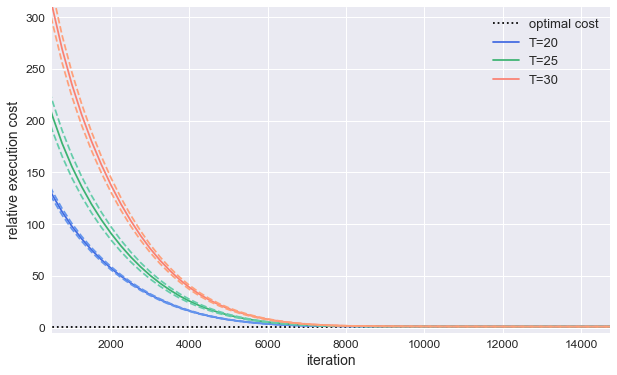

In [22]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)

costplot = pd.DataFrame(summary['iteration'],columns=['iteration'])
analytic_cost_scaled = np.ones(summary['history_length'])
costplot['optimal cost'] = analytic_cost_scaled

for c in np.arange(curves):
#for c in np.arange(2):
    summary = summaries[c]
    
    cost_history = summary['validation_cost_history']/summary['validation_cost_analytic']
    cost_mean = np.mean(cost_history,axis=1)
    cost_std = np.std(cost_history,axis=1)
    
    costplot['cost_mean'+str(c)] = cost_mean
    costplot['cost_lb'+str(c)] = (cost_mean - cost_std)
    costplot['cost_ub'+str(c)] = (cost_mean + cost_std)



    
    
costplot_p = costplot.plot.line(style = [':', '-', '--', '--', '-', '--', '--', '-', '--', '--'],color=['black','royalblue','cornflowerblue','cornflowerblue','mediumseagreen','mediumaquamarine','mediumaquamarine', 'salmon', 'lightsalmon', 'lightsalmon'],x='iteration')
costplot_p.set_xlim([500, 14750])
costplot_p.set_ylim([-5, 310])
costplot_p.set(xlabel='iteration', ylabel='relative execution cost')
costplot_p.set_xlabel(xlabel='iteration',size=14)
costplot_p.set_ylabel(ylabel='relative execution cost',size=14)
costplot_p.tick_params(labelsize=12)


costplot_p.legend(["optimal cost", "T=20",'_nolegend_','_nolegend_','T=25','_nolegend_','_nolegend_','T=30'],fontsize=13)



